In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box



In [2]:
# Open the GeoPackage vector file using GeoPandas
vector_file = "../../lidR/hulls_tolerance_2_5.gpkg"
gdf = gpd.read_file(vector_file)


In [3]:
# Open the raster file using Rasterio
raster_file = "../data/clean_data/solar/2230_175_0_5/2022_06_02_monthlyFlux.tif"
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)
    raster_transform = src.transform

In [6]:
# Use the Geopandas overlay function to create a mask of the overlapping areas
result = gpd.overlay(gdf, gdf, how='union')

/var/folders/qg/ghhvk02j7t3f3b9th5d2412rxxy23f/T/ipykernel_41123/3497724076.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 82 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = gpd.overlay(gdf, gdf, how='union')


In [20]:
# Open the raster file using Rasterio
raster_file = "../data/clean_data/solar/2230_175_0_5/2022_06_02_monthlyFlux.tif"
with rasterio.open(raster_file) as src:
    # Reproject the vector layer to match the raster's CRS (32631)
    gdf = gdf.to_crs(src.crs)

    # Read the raster data
    raster_data = src.read()
    raster_transform = src.transform

# Create a mask of the polygons on the raster
mask = geometry_mask(gdf['geometry'], out_shape=raster_data.shape[1:], transform=raster_transform)

# Invert the mask (True becomes False, and False becomes True)
inverse_mask = np.logical_not(mask)

# Set pixel values where polygons overlap to a specific value (e.g., 255)
for band in range(raster_data.shape[0]):
    # Calculate the minimum value for the current band
    min_value = np.min(raster_data[band])
    
    raster_data[band][inverse_mask] = min_value


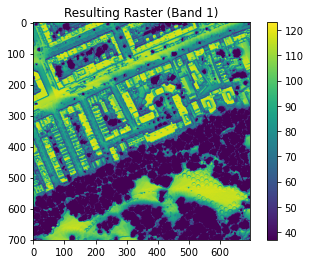

In [25]:
# Plot the resulting raster (you can choose a band to visualize)
# For example, to plot the first band:
plt.imshow(raster_data[7], cmap='viridis')
plt.colorbar()
plt.title('Resulting Raster (Band 1)')
plt.show()

In [26]:
# Calculate per pixel shade index
for band in range(raster_data.shape[0]):
    max_value = np.max(raster_data[band])
    raster_data[band] = 1 - (raster_data[band]/max_value)

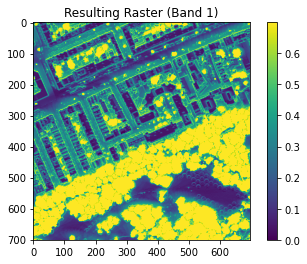

In [30]:
# Plot the resulting raster (you can choose a band to visualize)
# For example, to plot the first band:
plt.imshow(raster_data[7], cmap='viridis')
plt.colorbar()
plt.title('Resulting Raster (Band 1)')
plt.show()

In [32]:
# Save the modified raster including all bands
output_raster_file = "../results/output/2230_shade_index.tif"
with rasterio.open(output_raster_file, 'w', driver='GTiff', width=raster_data.shape[2], height=raster_data.shape[1], count=raster_data.shape[0], dtype=raster_data.dtype, crs=src.crs, transform=raster_transform) as dest:
    for band_idx in range(raster_data.shape[0]):
        dest.write(raster_data[band_idx], band_idx + 1)

# shade index average on verhardingen

In [2]:
# Open the raster file using Rasterio to get its extent
shade_index = "../results/output/2230_shade_index.tif"
with rasterio.open(shade_index) as src:
    shade_extent = src.bounds
    raster_bbox = box(src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top)
    raster_crs = src.crs


In [40]:
shade_extent

BoundingBox(left=626629.5, bottom=5802369.5, right=626978.5, top=5802720.0)

<AxesSubplot:>

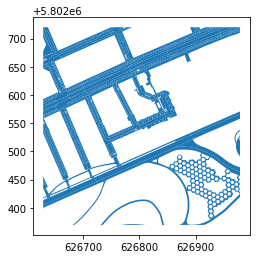

In [3]:
# Open the GeoPackage vector file using GeoPandas, filtering by the raster extent
verhardingen_file = "../../Land_Surface_Temperature/data/raw_data/AMS/verhardingen/Q1_20230126_ingekort.gpkg"
verhardingen = gpd.read_file(verhardingen_file).to_crs(raster_crs)
#No need to intersect, can directly clip.
#verhardingen = verhardingen[verhardingen.intersects(raster_bbox)]
verhardingen = verhardingen.clip(raster_bbox)
verhardingen.plot()


<AxesSubplot:>

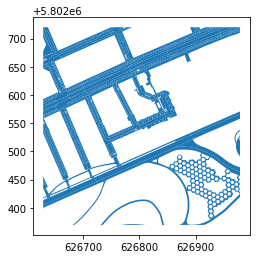

In [4]:
#Calculate shade index per verhardingen surface for all of the months and add them as individual columns.
with rasterio.open(shade_index) as src:
    # Read the raster bands
    bands = [src.read(band_idx) for band_idx in range(1, src.count + 1)]
    # Get the raster's spatial reference
    crs = src.crs
     # Iterate over the polygons
    for index, row in verhardingen.iterrows():
        polygon = row['geometry']
        # Initialize a list to store average values for each band
        average_values = []
        # Iterate over the bands
        for band_idx, band in enumerate(bands):
            # Use the polygon to clip the band
            clipped_band, _ = rasterio.mask.mask(src, [polygon], crop=True, nodata=np.nan, indexes=band_idx + 1)
            # Calculate the average pixel value for this band within the polygon
            average_pixel_value = np.nanmean(clipped_band)
            average_values.append(average_pixel_value)
        # Add the average pixel values to new columns in the GeoDataFrame
        for band_idx, avg_value in enumerate(average_values):
            verhardingen.at[index, f'Shade_index_M_{band_idx+1}'] = avg_value

/var/folders/qg/ghhvk02j7t3f3b9th5d2412rxxy23f/T/ipykernel_92376/543024968.py:17: RuntimeWarning: Mean of empty slice
  average_pixel_value = np.nanmean(clipped_band)


In [5]:
# Save for vis.
verhardingen_repr = verhardingen.to_crs(4326)
verhardingen_repr.to_file('../results/output/2230_shade_index.geojson', driver='GeoJSON')

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Checking whether the verhardingen dataset overlaps correctly.

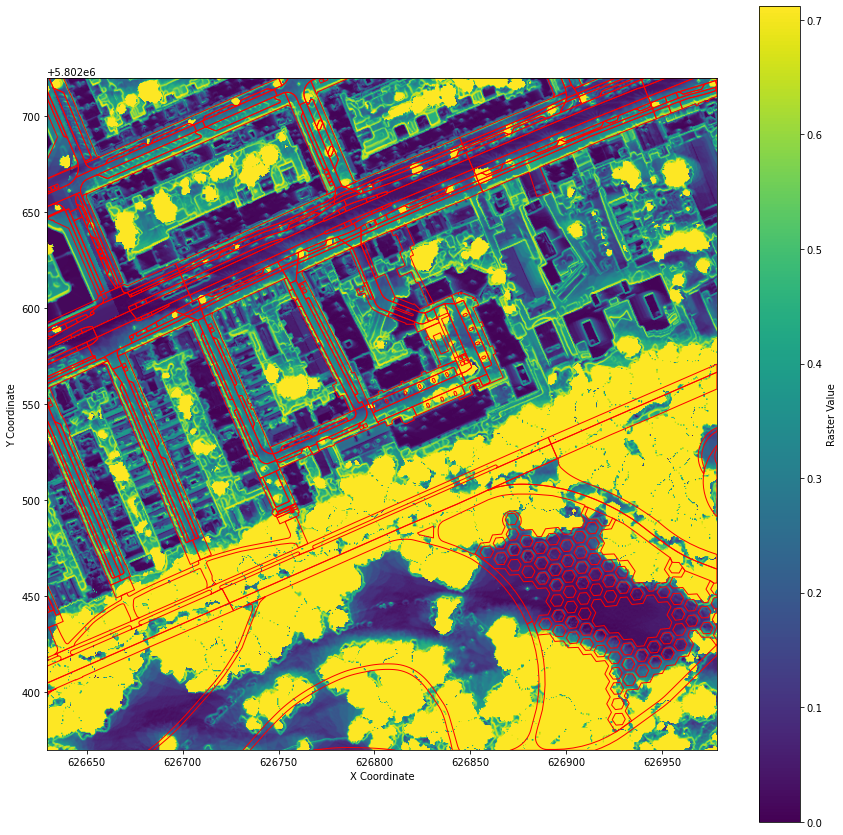

In [6]:
with rasterio.open(shade_index) as src:
    # Read the raster data for visualization (you can choose a specific band if needed)
    raster_data = src.read(7)  # Replace "1" with the band index you want to visualize
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]



# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the raster data
cax = ax.imshow(raster_data, cmap='viridis', extent=raster_extent, origin='upper')

# Plot the vector data on top
verhardingen.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

# Add a colorbar for the raster
plt.colorbar(cax, ax=ax, label='Raster Value')

# Set axis labels
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Show the plot
plt.show()

In [7]:
# Save the GeoDataFrame with the new columns
output_vector_file = "2230_verhardingen_shade_index.gpkg"
gdf.to_file(output_vector_file, driver='GPKG')

NameError: name 'gdf' is not defined

# Next one

In [8]:
# Open the GeoPackage vector file using GeoPandas
vector_file = "../../lidR/results/25GN1_12.gpkg"
gdf = gpd.read_file(vector_file)


In [35]:
# Open the raster file using Rasterio
raster_file = "../data/clean_data/solar/2236_175_0_5/2017_05_25_monthlyFlux.tif"
with rasterio.open(raster_file) as src:
    raster_data = src.read(1)
    raster_transform = src.transform

In [ ]:
# Use the Geopandas overlay function to create a mask of the overlapping areas
result = gpd.overlay(gdf, gdf, how='union')

In [36]:
# Open the raster file using Rasterio
raster_file = "../data/clean_data/solar/2236_175_0_5/2017_05_25_monthlyFlux.tif"
with rasterio.open(raster_file) as src:
    # Reproject the vector layer to match the raster's CRS (32631)
    gdf = gdf.to_crs(src.crs)

    # Read the raster data
    raster_data = src.read()
    raster_transform = src.transform

# Create a mask of the polygons on the raster
mask = geometry_mask(gdf['geometry'], out_shape=raster_data.shape[1:], transform=raster_transform)

# Invert the mask (True becomes False, and False becomes True)
inverse_mask = np.logical_not(mask)

# Set pixel values where polygons overlap to a specific value (e.g., 255)
for band in range(raster_data.shape[0]):
    # Calculate the minimum value for the current band
    min_value = np.min(raster_data[band])
    
    raster_data[band][inverse_mask] = min_value


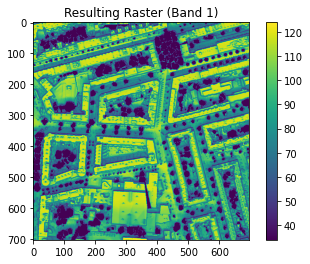

In [37]:
# Plot the resulting raster (you can choose a band to visualize)
# For example, to plot the first band:
plt.imshow(raster_data[7], cmap='viridis')
plt.colorbar()
plt.title('Resulting Raster (Band 1)')
plt.show()

In [38]:
# Calculate per pixel shade index
for band in range(raster_data.shape[0]):
    max_value = np.max(raster_data[band])
    raster_data[band] = 1 - (raster_data[band]/max_value)

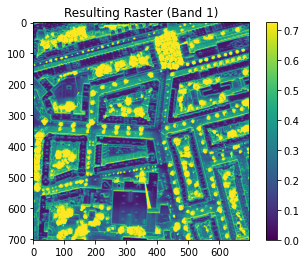

In [39]:
# Plot the resulting raster (you can choose a band to visualize)
# For example, to plot the first band:
plt.imshow(raster_data[7], cmap='viridis')
plt.colorbar()
plt.title('Resulting Raster (Band 1)')
plt.show()

In [8]:
# Save the modified raster including all bands
output_raster_file = "../results/output/2236_shade_index.tif"
with rasterio.open(output_raster_file, 'w', driver='GTiff', width=raster_data.shape[2], height=raster_data.shape[1], count=raster_data.shape[0], dtype=raster_data.dtype, crs=src.crs, transform=raster_transform) as dest:
    for band_idx in range(raster_data.shape[0]):
        dest.write(raster_data[band_idx], band_idx + 1)

Shade index on verhardingen

In [13]:
# Open the raster file using Rasterio to get its extent
shade_index = "../results/output/2236_shade_index.tif"
with rasterio.open(shade_index) as src:
    shade_extent = src.bounds
    raster_bbox = box(src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top)
    raster_crs = src.crs


<AxesSubplot:>

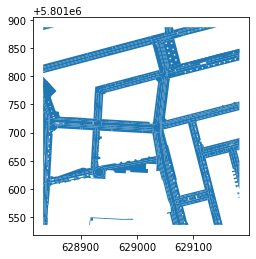

In [10]:
# Open the GeoPackage vector file using GeoPandas, filtering by the raster extent
verhardingen_file = "../../Land_Surface_Temperature/data/raw_data/AMS/verhardingen/Q1_20230126_ingekort.gpkg"
verhardingen = gpd.read_file(verhardingen_file).to_crs(raster_crs)
verhardingen.geometry = verhardingen.geometry.buffer(0)
#No need to intersect, can directly clip.
# verhardingen = verhardingen[verhardingen.intersects(raster_bbox)]
verhardingen = verhardingen.clip(raster_bbox)
verhardingen.plot()


In [22]:
verhardingen.head()

,Guid,Objecttype,Type,Type_gedetailleerd,Type_extra_gedetailleerd,Kleur,Type_rijstrook,Gebruiksfunctie,Wegtype_bestaand,Jaar_uitgevoerd_onderhoud,Jaar_laatste_conservering,Jaar_van_aanleg,Oppervlakte_GIS,Beheerder_gedetailleerd,Onderhoudsplichtige,geometry
33751,{60F03032-AD6F-4549-A49C-3E9D6ACF6E2C},Verhardingsobject,Elementenverharding,Betonstraatstenen,Betonsteen,Grijs,None,Parkeervak,5 - Weg in woongebied,2010.0,NaN,1990.0,14.940000,R&E_VOR_Verhardingen,None,"POLYGON ((628845.297 5801688.840, 628845.316 5..."
33749,{5B6CD7BB-E777-4ACA-A6D4-68A7C9212EF8},Verhardingsobject,Elementenverharding,Betonstraatstenen,Betonsteen,Grijs,None,Parkeervak,5 - Weg in woongebied,NaN,NaN,2017.0,13.060000,R&E_VOR_Verhardingen,None,"POLYGON ((628844.295 5801701.420, 628845.817 5..."
163955,{950F2985-C8E1-4374-9A2E-65714054731F},Verhardingsobject,Asfaltverharding,Dichte deklagen,Asfaltbeton,Grijs,None,OV-baan,2 - Zwaar belaste weg,NaN,NaN,2017.0,306.510000,R&E_VOR_Verhardingen,None,"POLYGON ((628836.396 5801737.397, 628836.666 5..."
100979,{DBCA41ED-B8D5-4ABE-9868-789080E5BE1F},Verhardingsobject,Elementenverharding,Tegels,Betontegel,Grijs,None,Voetpad,6 - Weg in verblijfsgebied,2005.0,NaN,1980.0,187.340000,R&E_VOR_Verhardingen,None,"POLYGON ((628899.738 5801710.060, 628899.503 5..."
177810,{50ACB96A-B3DF-44D0-BCA0-E1A927AF3773},Verhardingsobject,Elementenverharding,Straatbaksteen,Gebakken steen,Rood,None,Voetpad,6 - Weg in verblijfsgebied,NaN,NaN,2022.0,6.046749,R&E_VOR_Verhardingen,None,"POLYGON ((628838.746 5801710.900, 628838.816 5..."


In [11]:
## "SIMPLE" METHOD CALCULATING JUST THE AVERAGE USING A MASK FOR EACH INDIVIDUAL POLYGON

#Calculate shade index per verhardingen surface for all of the months and add them as individual columns.
with rasterio.open(shade_index) as src:
    # Read the raster bands
    bands = [src.read(band_idx) for band_idx in range(1, src.count + 1)]
    # Get the raster's spatial reference
    crs = src.crs
     # Iterate over the polygons
    for index, row in verhardingen.iterrows():
        polygon = row['geometry']
        # Initialize a list to store average values for each band
        average_values = []
        # Iterate over the bands
        for band_idx, band in enumerate(bands):
            # Use the polygon to clip the band
            clipped_band, _ = rasterio.mask.mask(src, [polygon], crop=True, nodata=np.nan, indexes=band_idx + 1)
            # Calculate the average pixel value for this band within the polygon
            average_pixel_value = np.nanmean(clipped_band)
            average_values.append(average_pixel_value)
        # Add the average pixel values to new columns in the GeoDataFrame
        for band_idx, avg_value in enumerate(average_values):
            verhardingen.at[index, f'Shade_index_M_{band_idx+1}'] = avg_value

/var/folders/qg/ghhvk02j7t3f3b9th5d2412rxxy23f/T/ipykernel_92376/2920478750.py:19: RuntimeWarning: Mean of empty slice
  average_pixel_value = np.nanmean(clipped_band)


In [12]:
from rasterstats import zonal_stats

In [14]:
## Nice method to easily get more descriptive statistics for each verhardingen surface.

#Calculate shade index per verhardingen surface for all of the months and add them as individual columns.
verhardingen = verhardingen.reset_index()
with rasterio.open(shade_index) as src:
    # Read the raster bands
    bands = [src.read(band_idx) for band_idx in range(1, src.count + 1)]
    affine = src.transform
    crs = src.crs
    month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    # Iterate over bands and compute statistics for the whole verhardingen dataset
    for band_idx, band in enumerate(bands):
        band_stats = zonal_stats(verhardingen, band, affine=affine, stats=['min','max','mean','median','sum','range','std'], nodata=-999)
        #band_stats are saved in a dictionary. We use the dictionary to add these to the respective row in verhardingen, creating a new column for each stat and band.
        for idx, item in verhardingen.iterrows():
            row_stats = band_stats[idx]
            for key, value in row_stats.items():
                verhardingen.at[idx, f'SI_{month_list[band_idx]}_{key}'] = value


In [6]:
verhardingen.head()

,index,Guid,Objecttype,Type,Type_gedetailleerd,Type_extra_gedetailleerd,Kleur,Type_rijstrook,Gebruiksfunctie,Wegtype_bestaand,...,SI_Nov_std,SI_Nov_median,SI_Nov_range,SI_Dec_min,SI_Dec_max,SI_Dec_mean,SI_Dec_sum,SI_Dec_std,SI_Dec_median,SI_Dec_range
0,33751,{60F03032-AD6F-4549-A49C-3E9D6ACF6E2C},Verhardingsobject,Elementenverharding,Betonstraatstenen,Betonsteen,Grijs,None,Parkeervak,5 - Weg in woongebied,...,0.035354,0.792850,0.213379,0.566884,0.782527,0.775531,44.205288,0.036810,0.782527,0.215643
1,33749,{5B6CD7BB-E777-4ACA-A6D4-68A7C9212EF8},Verhardingsobject,Elementenverharding,Betonstraatstenen,Betonsteen,Grijs,None,Parkeervak,5 - Weg in woongebied,...,0.027896,0.792850,0.154122,0.614390,0.782527,0.776445,40.375126,0.030472,0.782527,0.168136
2,163955,{950F2985-C8E1-4374-9A2E-65714054731F},Verhardingsobject,Asfaltverharding,Dichte deklagen,Asfaltbeton,Grijs,None,OV-baan,2 - Zwaar belaste weg,...,0.088008,0.528608,0.304283,0.496964,0.782527,0.565106,580.363770,0.083438,0.535078,0.285562
3,100979,{DBCA41ED-B8D5-4ABE-9868-789080E5BE1F},Verhardingsobject,Elementenverharding,Tegels,Betontegel,Grijs,None,Voetpad,6 - Weg in verblijfsgebied,...,0.077591,0.618477,0.396811,0.425551,0.782527,0.632594,473.813171,0.081235,0.592775,0.356976
4,177810,{50ACB96A-B3DF-44D0-BCA0-E1A927AF3773},Verhardingsobject,Elementenverharding,Straatbaksteen,Gebakken steen,Rood,None,Voetpad,6 - Weg in verblijfsgebied,...,0.088449,0.591480,0.202083,0.563198,0.782527,0.635297,15.247131,0.095800,0.563959,0.219328


In [15]:
# Save for vis.
verhardingen_repr = verhardingen.to_crs(4326)
verhardingen_repr.to_file('../results/output/2236_shade_index.geojson', driver='GeoJSON')

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [17]:
# Save for vis.
verhardingen_repr = verhardingen.to_crs(4326)
verhardingen_repr.to_file('../results/output/2236_shade_index_test.json', driver='GeoJSON')

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


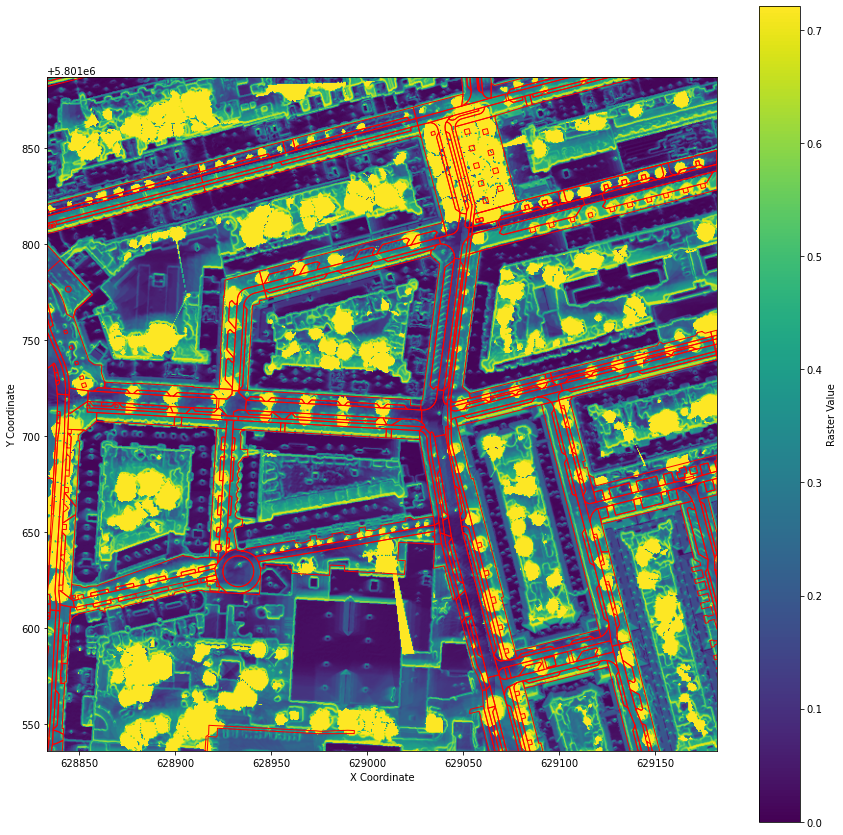

In [16]:
with rasterio.open(shade_index) as src:
    # Read the raster data for visualization (you can choose a specific band if needed)
    raster_data = src.read(7)  # Replace "1" with the band index you want to visualize
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]



# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the raster data
cax = ax.imshow(raster_data, cmap='viridis', extent=raster_extent, origin='upper')

# Plot the vector data on top
verhardingen.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

# Add a colorbar for the raster
plt.colorbar(cax, ax=ax, label='Raster Value')

# Set axis labels
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Show the plot
plt.show()

# Visualisation

In [26]:
import matplotlib

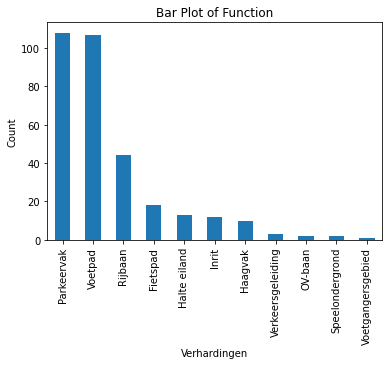

In [7]:
# Group data by the column and count the occurrences
counts = verhardingen["Gebruiksfunctie"].value_counts()

# Plot the bar chart
counts.plot(kind='bar')
plt.xlabel('Verhardingen')
plt.ylabel('Count')
plt.title(f'Bar Plot of Function')
plt.show()

In [8]:
import seaborn as sns

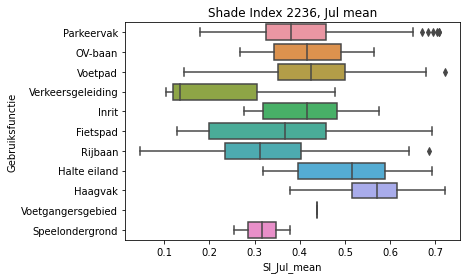

In [22]:
month = 'Jul'
stat = 'mean'
sns.boxplot(data=verhardingen, x=verhardingen[f'SI_{month}_{stat}'],y=verhardingen['Gebruiksfunctie']).set(title=f'Shade Index 2236, {month} {stat}')
# seaborn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'figure.figsize':(11.7,8.27)})
# seaborn.set_theme(style='whitegrid')
# plt.xlabel('Temp. difference in °C')
# plt.tight_layout()
# plt.savefig('../results/figures/Airtemp_LST_NL_DateTime_1050.png', dpi=300)
plt.show()

In [15]:
verhardingen['SI_Jul_mean'].describe()

count    318.000000
mean       0.401847
std        0.134487
min        0.047668
25%        0.315829
50%        0.391482
75%        0.480527
max        0.720760
Name: SI_Jul_mean, dtype: float64